In [1]:
import numpy as np
import os
from keras import backend as K
import pandas as pd

Using TensorFlow backend.


In [2]:
directory_reco = "/data/km3net/extracted_trees_reco_files"
reco_files_numu = [os.path.join(directory_reco, "km3_v4_numuCC_{}.evt.JEnergy.rootreco_trees.npz".format(i+1)) 
                   for i in range(100)]
reco_files_nue = [os.path.join(directory_reco, "km3_v4_nueCC_{}.evt.JEnergy.rootreco_trees.npz".format(i+1))
                  for i in range(100)]

In [3]:
doms_map_files_numu = ["/data/km3net/Xy_multi_data_files/numu_{}_sel5_doms_map.npz".format(i+1) for i in range(100)] 
doms_map_files_nue = ["/data/km3net/Xy_multi_data_files/nue_{}_sel_5_doms_map.npz".format(i+1) for i in range(100)]    

In [4]:
index_files = ["train_test_files/Xy_indx{}_sel5_doms.npz".format(i+1) for i in range(100)]
test_indices = [np.load(index_files[i])["test"] for i in range(100)]

In [5]:
def sel_doms_arr(data_filepath, map_filepath, target_key):
    """Selects all events with more than 5 doms hits - according to the input doms_map"""
    with np.load(data_filepath) as data_file, np.load(map_filepath) as map_file:
        return data_file[target_key][map_file["id"]]

In [6]:
from generators import get_n_iterations, metadata_generator, data_generator
from tqdm import tqdm
n_files=100
batch_size=64


In [7]:
nu_stack_dirx = [np.hstack((sel_doms_arr(reco_files_numu[i], doms_map_files_numu[i], "dirx"),
                            sel_doms_arr(reco_files_nue[i], doms_map_files_nue[i], "dirx"))) for i in range(100)]
nu_stack_diry = [np.hstack((sel_doms_arr(reco_files_numu[i], doms_map_files_numu[i], "diry"),
                            sel_doms_arr(reco_files_nue[i], doms_map_files_nue[i], "diry"))) for i in range(100)]
nu_stack_dirz = [np.hstack((sel_doms_arr(reco_files_numu[i], doms_map_files_numu[i], "dirz"),
                            sel_doms_arr(reco_files_nue[i], doms_map_files_nue[i], "dirz"))) for i in range(100)]

In [8]:
y_reco_dx = np.hstack(nu_stack_dirx[i][test_indices[i]] for i in range(100))
y_reco_dy = np.hstack(nu_stack_diry[i][test_indices[i]] for i in range(100))
y_reco_dz = np.hstack(nu_stack_dirz[i][test_indices[i]] for i in range(100))
print(y_reco_dx.shape, y_reco_dx.shape, y_reco_dz.shape)

((51818,), (51818,), (51818,))


In [9]:
train_test_dir = os.path.abspath("./cosz")
fnames_test =[os.path.join(train_test_dir, "Xy_test{}_sel5_doms.npz".format(i+1)) for i in range(100)]
index_filelist = [os.path.join(train_test_dir, "Xy_indx{}_sel5_doms.npz".format(i+1)) for i in range(100)]

dir_xy = os.path.join("/", "data", "km3net", "Xy_multi_data_files")
xy_filelist = [(os.path.join(dir_xy, "Xy_numu_{}_multi_data.npz".format(i+1)), 
                os.path.join(dir_xy, "Xy_nue_{}_multi_data.npz".format(i+1))) for i in range(100)]
metadata_keylist = ["E", "dirx", "diry", "dirz", "posx","posy","posz", "dist"]

In [11]:
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], batch_size=64)
print(predict_steps, n_test_events)

(810, 51818)


In [12]:
y_true = list()
metadata = None
metadata_gen  = metadata_generator(index_filelist, xy_filelist, metadata_keylist)
data_gen = data_generator(fnames_test[:n_files], batch_size=batch_size, 
                          ftarget=lambda y: y)

for i in tqdm(range(predict_steps)):
    _, y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))
    y_true.append(y_batch_true)
    
y_true = np.hstack(np.asarray(y_true))

100%|██████████| 810/810 [00:38<00:00, 21.16it/s]


In [17]:
true_dx = np.asarray(metadata["dirx"])
true_dy = np.asarray(metadata["diry"])
true_dz = np.asarray(metadata["dirz"])

In [106]:
true_dx.shape

(51818,)

In [107]:
true_dir = np.vstack((true_dx, true_dy, true_dz))
true_dir.shape

(3, 51818)

In [113]:
y_reco_dir = np.vstack((y_reco_dx, y_reco_dy, y_reco_dz))
y_reco_dir.shape

(3, 51818)

In [126]:
angle = []
for i in range(true_dx.shape[0]):
    angle_i = np.degrees(np.arccos(np.round(y_reco_dx[i]*true_dx[i] + 
                                            y_reco_dy[i]*true_dy[i] + 
                                            y_reco_dz[i]*true_dz[i], decimals=5)))
    angle.append(angle_i)

In [127]:
np.min(angle), np.max(angle)

(0.0, 176.90352975245423)

In [138]:
log_angle=np.log10(angle)[np.isfinite(np.log10(angle))]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


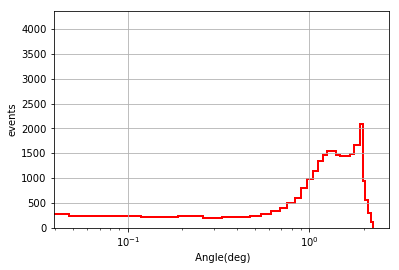

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(log_angle, label="reco_evts", 
         bins=40, histtype="step", color="red",lw=2)
plt.grid()
plt.xlabel(" Angle(deg)")
plt.ylabel("events")
plt.xscale("Log")
#plt.xlim(1e-2, 1e1)
#plt.legend(loc="upper right")

(0.001, 100.0)

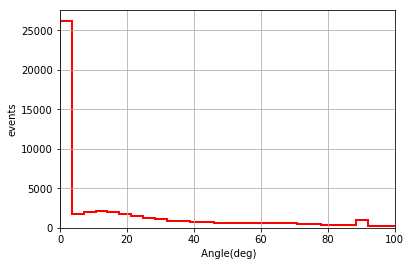

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(angle, label="reco_evts", 
         bins=50, histtype="step", color="red",lw=2)
plt.grid()
plt.xlabel(" Angle(deg)")
plt.ylabel("events")
plt.xlim(1e-3, 1e2)